In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patheffects import withStroke

## Temp Data
Source: https://www.ncei.noaa.gov/products/land-based-station/noaa-global-temp

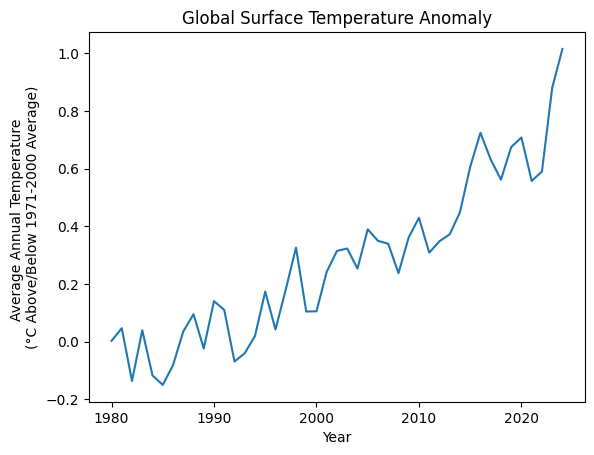

In [2]:
freq = 'ann'
area = 'land_ocean'
limits = '90S.90N'
yyymm = '202402'
url = f'https://www.ncei.noaa.gov/data/noaa-global-surface-temperature/v6/access/timeseries/aravg.{freq}.{area}.{limits}.v6.0.0.{yyymm}.asc'

temps = pd.read_csv(url, header=None, delimiter=r'\s+')
temps.columns = ['year', 'temp_anomaly', 'error1', 'error2', 'error3', 'error4']
temps = temps[temps.year >= 1980]

plt.figure()
plt.plot(temps['year'], temps['temp_anomaly'])
plt.title('Global Surface Temperature Anomaly')
plt.xlabel('Year')
plt.ylabel('Average Annual Temperature \n(\u00B0C Above/Below 1971-2000 Average)')
plt.show()

## Accumulated Cyclone Energy (ACE) Index Data
Source: https://www.epa.gov/climate-indicators/climate-change-indicators-tropical-cyclone-activity

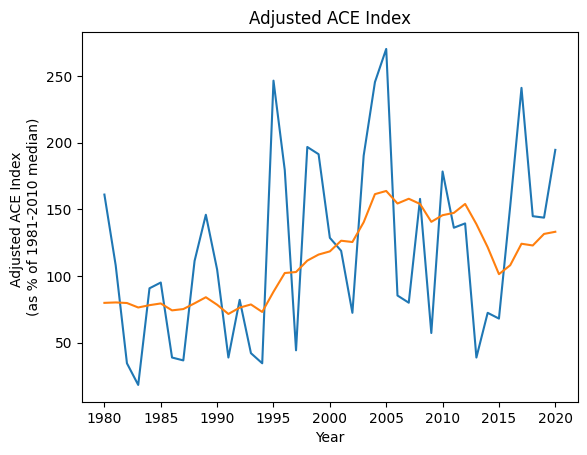

In [3]:
url = 'https://www.epa.gov/sites/default/files/2021-04/cyclones_fig-2.csv'

ace = pd.read_csv(url, encoding='cp1252', skiprows=6)
ace.columns = ['year', 'ace']
ace['moving_average'] = ace.ace.rolling(10).mean()
ace = ace[ace.year >= 1980]

plt.figure()
plt.plot(ace['year'], ace.ace)
plt.plot(ace['year'], ace['moving_average'])
plt.title('Adjusted ACE Index')
plt.xlabel('Year')
plt.ylabel('Adjusted ACE Index \n(as % of 1981-2010 median)')
plt.show()

Source: https://psl.noaa.gov/gcos_wgsp/Timeseries/Hurricane/

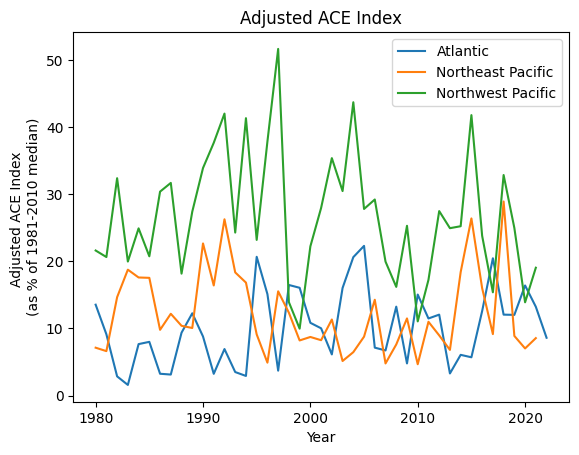

In [4]:
regions = ['atl', 'nepac', 'nwpac']
ace = pd.DataFrame()

for region in regions:
    url = f'https://psl.noaa.gov/gcos_wgsp/Timeseries/Hurricane/hurr.{region}.ace.data'
    df = pd.read_csv(url, header=None, delimiter=r'\s+', skiprows=1).dropna(how='any').apply(pd.to_numeric)
    df = df.set_index(0, drop=True)
    df[f'ace_{region}'] = df.apply(lambda x: x[1:].mean(), axis=1)
    ace = pd.merge(ace, df[[f'ace_{region}']], left_index=True, right_index=True, how='outer')

ace = ace[ace.index >= 1980]

plt.figure()
plt.plot(ace.index, ace['ace_atl'], label='Atlantic')
plt.plot(ace.index, ace['ace_nepac'], label='Northeast Pacific')
plt.plot(ace.index, ace['ace_nwpac'], label='Northwest Pacific')
plt.legend()
plt.title('Adjusted ACE Index')
plt.xlabel('Year')
plt.ylabel('Adjusted ACE Index \n(as % of 1981-2010 median)')
plt.show()

## Economic Cost Data
Source: https://public.emdat.be/

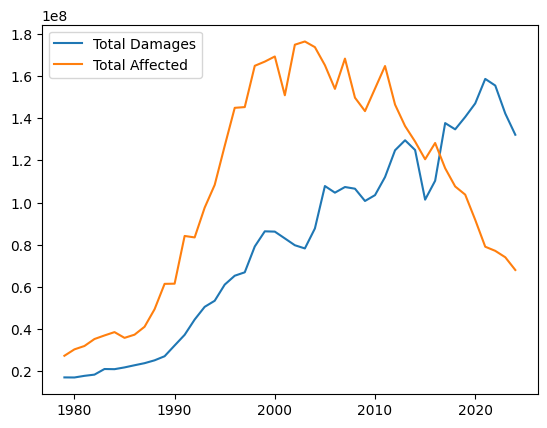

In [5]:
emdat = pd.read_excel('data/emdat_hydro_metereo_1980.xlsx', engine='openpyxl')

damage_per_year = emdat.groupby('End Year').agg({
    "Total Damage, Adjusted ('000 US$)": "sum",
}).rolling(10).mean()
damage_per_year.columns = ['rolling_10yr_damages']

affected_per_year = emdat.groupby('End Year').agg({
    "Total Affected": "sum",
}).rolling(10).mean()

plt.figure()
plt.plot(damage_per_year, label='Total Damages')
plt.plot(affected_per_year, label='Total Affected')
plt.legend()
plt.show()

## Visualizations

In [6]:
df = pd.merge(temps, damage_per_year, left_on='year', right_index=True, how='outer').dropna(how='any')
df = df[df.year >= 1990]
df['rolling_10yr_damages'] = df['rolling_10yr_damages'] / 10**6
df.head()

,year,temp_anomaly,error1,error2,error3,error4,rolling_10yr_damages
140.0,1990,0.140700,-999.0,-999.0,-999.0,-999.0,32.042610
141.0,1991,0.110018,-999.0,-999.0,-999.0,-999.0,37.101758
142.0,1992,-0.068734,-999.0,-999.0,-999.0,-999.0,44.368372
143.0,1993,-0.039869,-999.0,-999.0,-999.0,-999.0,50.412372
144.0,1994,0.019904,-999.0,-999.0,-999.0,-999.0,53.300087


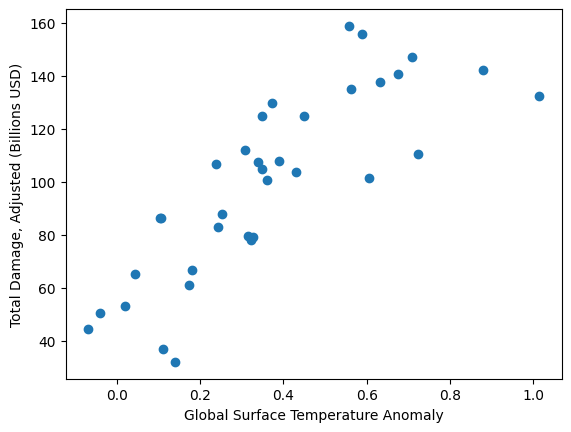

In [7]:
plt.figure()
plt.scatter(df['temp_anomaly'], df['rolling_10yr_damages'])
plt.xlabel('Global Surface Temperature Anomaly')
plt.ylabel('Total Damage, Adjusted (Billions USD)')
plt.show()

/var/folders/yd/dq0ds2hn6rs32t4__d98lrsc0000gn/T/ipykernel_54259/2912075419.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r')


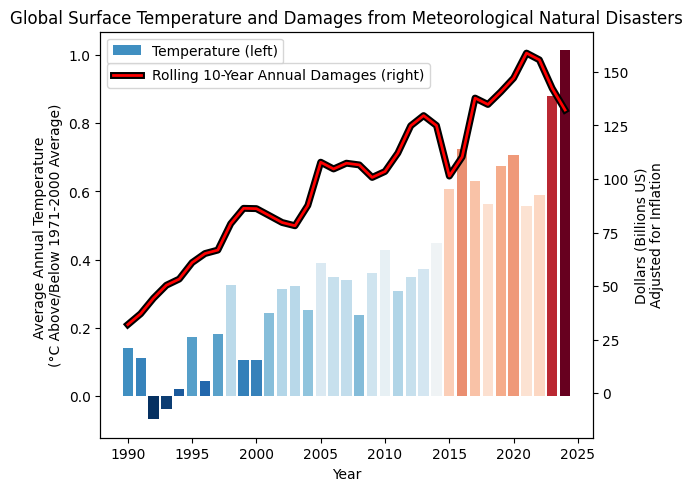

In [12]:
plt.figure(layout='constrained')
ax1 = plt.gca()

norm = mcolors.Normalize(vmax=df["temp_anomaly"].max(), vmin=df["temp_anomaly"].min())
cmap = plt.cm.get_cmap('RdBu_r')
colors = cmap(norm(df["temp_anomaly"]))

ax1.bar(df['year'], df["temp_anomaly"], color=colors, label='Temperature (left)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Annual Temperature \n(\u00B0C Above/Below 1971-2000 Average)')

# Create a secondary y-axis for the line plot
ax2 = ax1.twinx()
ax2.plot(
    df['year'], df['rolling_10yr_damages'], 
    color='red', linewidth=2, label='Rolling 10-Year Annual Damages (right)',
    path_effects=[withStroke(linewidth=5, foreground='black')]
)
ax2.set_ylabel('Dollars (Billions US)\nAdjusted for Inflation')
ratio = df['rolling_10yr_damages'].max() / df["temp_anomaly"].max()
ax2.set_ylim([(df["temp_anomaly"].min() * ratio - 10), df['rolling_10yr_damages'].max() + 10])

ax1.legend(loc='upper left')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.94))

plt.title('Global Surface Temperature and Damages from Meteorological Natural Disasters')

plt.show()